# **Libraries**

In [1]:
import h5py
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from itertools import combinations
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict

In [2]:
test_size    = 0.20
seed         = 9
h5_color     = '/home/operador2020/AI_bases_framework/color_features.h5'
h5_colorLb   = '/home/operador2020/AI_bases_framework/color_features_labels.h5'
h5_texture   = '/home/operador2020/AI_bases_framework/textural_features.h5'
h5_textureLb = '/home/operador2020/AI_bases_framework/textural_features_labels.h5'
scoring      = {'accuracy' : make_scorer(accuracy_score),
                'f1_score' : make_scorer(f1_score, average = 'weighted'), 
                'precision' : make_scorer(precision_score, average = 'weighted'),
                'recall' : make_scorer(recall_score, average = 'weighted')}


# **Load Data**

In [3]:
# import the feature vector and trained labels
h5f_color   = h5py.File(h5_color, 'r')
h5f_colorLb = h5py.File(h5_colorLb, 'r')

color_features_string          = h5f_color['Banana_Ripeness_Color_Features']
color_features_labels_string   = h5f_colorLb['Banana_Ripeness_Color_Features_Labels']

color_features = np.array(color_features_string)
color_features_labels  = np.array(color_features_labels_string)

h5f_color.close()
h5f_colorLb.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(color_features.shape))
print("[STATUS] labels shape: {}".format(color_features_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (1242, 512)
[STATUS] labels shape: (1242,)
[STATUS] training started...


In [4]:
# import the feature vector and trained labels
h5f_texture  = h5py.File(h5_texture, 'r')
h5f_textureLb = h5py.File(h5_textureLb, 'r')

textural_features_string          = h5f_texture['Banana_Ripeness_Textural_Features']
textural_features_labels_string   = h5f_textureLb['Banana_Ripeness_Textural_Features_Labels']

textural_features = np.array(textural_features_string )
textural_features_labels  = np.array(textural_features_labels_string)

h5f_texture.close()
h5f_textureLb.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(textural_features.shape))
print("[STATUS] labels shape: {}".format(textural_features_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (1242, 13)
[STATUS] labels shape: (1242,)
[STATUS] training started...


In [5]:
global_features = np.hstack([color_features, textural_features])
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(textural_features_labels.shape))

[STATUS] features shape: (1242, 525)
[STATUS] labels shape: (1242,)


# **Identify X and Y**

In [6]:
X = global_features
Y = color_features_labels

# **Training and Testing**

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                        test_size   = test_size,
                                        random_state = seed)

X_train.shape, X_test.shape

((993, 525), (249, 525))

# **Applying PCA**

In [8]:
pca = PCA(n_components = 19)
pca.fit(X_train)
X_train_transformed = pca.transform(X_train)
X_test_transformed = pca.transform(X_test)

print(X_train_transformed.shape, X_test_transformed.shape)

(993, 19) (249, 19)


<BarContainer object of 19 artists>

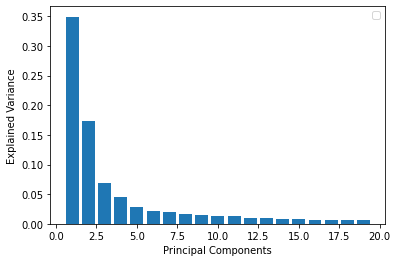

In [9]:
plt.legend('')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.bar(list(range(1, X_train_transformed.shape[1]+1)),pca.explained_variance_ratio_)

# **SVM**

In [10]:
linear_param_grid = {
    
        "kernel": ["linear"],
        "C": [0.0001, 0.001, 0.1, 1, 10, 100, 1000],
        "decision_function_shape": ['ovo', 'ovr']
}

In [11]:
poly_param_grid = {
    
        "kernel": ["poly"],
        "degree": [2, 3, 4],
        "C": [0.0001, 0.001, 0.1, 1, 10, 100, 1000],
        "decision_function_shape": ['ovo', 'ovr']
}

In [27]:
rbf_param_grid = {
        "kernel": ["rbf"],
        "gamma": ["auto", "scale"],
        "C": [0.0001, 0.001, 0.1, 1, 10, 100, 1000],
        "decision_function_shape": ['ovo', 'ovr']
}

In [13]:
sigmoid_param_grid = {
        "kernel": ["sigmoid"],
        "gamma": ["auto", "scale"],
        "C": [0.0001, 0.001, 0.1, 1, 10, 100, 1000],
        "decision_function_shape": ['ovo', 'ovr']
}

### **Linear Kernel**

In [28]:
linear_grid = GridSearchCV(svm.SVC(), linear_param_grid)
linear_grid.fit(X_train_transformed,y_train)
print(linear_grid.best_estimator_)

SVC(C=10, decision_function_shape='ovo', kernel='linear')


In [29]:
linear_pred = linear_grid.predict(X_test_transformed)
linear_accuracy = accuracy_score(y_test, linear_pred)
linear_precision = precision_score(y_test, linear_pred, average='weighted')
linear_recall = recall_score(y_test, linear_pred, average='weighted')
linear_f1 = f1_score(y_test, linear_pred, average='weighted')
print('Accuracy (Linear Kernel): ', "%.5f" % (linear_accuracy*100))
print('F1 (Linear Kernel): ', "%.5f" % (linear_f1*100))
print('Precision (Linear Kernel): ', "%.5f" % (linear_precision*100))
print('Recall (Linear Kernel): ', "%.5f" % (linear_recall*100))

Accuracy (Linear Kernel):  96.38554
F1 (Linear Kernel):  96.38181
Precision (Linear Kernel):  96.38284
Recall (Linear Kernel):  96.38554


In [30]:
results = cross_validate(estimator=linear_grid, X=X_train_transformed, y=y_train, cv=6, scoring=scoring)

print('Accuracy (Linear Kernel): ', "%.5f" % (np.mean(results['test_accuracy'])*100))
print('F1 (Linear Kernel): ', "%.5f" % (np.mean(results['test_f1_score'])*100))
print('Precision (Linear Kernel): ', "%.5f" % (np.mean(results['test_precision'])*100))
print('Recall (Linear Kernel): ', "%.5f" % (np.mean(results['test_recall'])*100))

Accuracy (Linear Kernel):  97.48083
F1 (Linear Kernel):  97.47990
Precision (Linear Kernel):  97.51840
Recall (Linear Kernel):  97.48083


### **Polynomial Kernel**

In [31]:
poly_grid = GridSearchCV(svm.SVC(probability=True), poly_param_grid)
poly_grid.fit(X_train_transformed,y_train)
print(poly_grid.best_estimator_)

SVC(C=100, decision_function_shape='ovo', kernel='poly', probability=True)


In [32]:
poly_pred = poly_grid.predict(X_test_transformed)
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_precision = precision_score(y_test, poly_pred, average='weighted')
poly_recall = recall_score(y_test, poly_pred, average='weighted')
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))
print('Precision (Polynomial Kernel): ', "%.2f" % (poly_precision*100))
print('Recall (Polynomial Kernel): ', "%.2f" % (poly_recall*100))

Accuracy (Polynomial Kernel):  99.60
F1 (Polynomial Kernel):  99.60
Precision (Polynomial Kernel):  99.60
Recall (Polynomial Kernel):  99.60


In [33]:
results = cross_validate(estimator=poly_grid, X=X_train_transformed, y=y_train, cv=8, scoring=scoring)

print('Accuracy (Polynomial Kernel): ', "%.2f" % (np.mean(results['test_accuracy'])*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (np.mean(results['test_f1_score'])*100))
print('Precision (Polynomial Kernel): ', "%.2f" % (np.mean(results['test_precision'])*100))
print('Recall (Polynomial Kernel): ', "%.2f" % (np.mean(results['test_recall'])*100))

Accuracy (Polynomial Kernel):  98.69
F1 (Polynomial Kernel):  98.69
Precision (Polynomial Kernel):  98.72
Recall (Polynomial Kernel):  98.69


### **RBF Kernel**

In [32]:
rbf_grid = GridSearchCV(svm.SVC(probability=True), rbf_param_grid)
rbf_grid.fit(X_train_transformed,y_train)
print(rbf_grid.best_estimator_)

SVC(C=10, decision_function_shape='ovo', probability=True)


In [33]:
rbf_pred = rbf_grid.predict(X_test_transformed)
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_precision = precision_score(y_test, rbf_pred, average='weighted')
rbf_recall = recall_score(y_test, rbf_pred, average='weighted')
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))
print('Precision (RBF Kernel): ', "%.2f" % (rbf_precision*100))
print('Recall (RBF Kernel): ', "%.2f" % (rbf_recall*100))

Accuracy (RBF Kernel):  99.60
F1 (RBF Kernel):  99.60
Precision (RBF Kernel):  99.60
Recall (RBF Kernel):  99.60


In [34]:
results = cross_validate(estimator=rbf_grid, X=X_train_transformed, y=y_train, cv=8, scoring=scoring)

print('Accuracy (RBF Kernel): ', "%.2f" % (np.mean(results['test_accuracy'])*100))
print('F1 (RBF Kernel): ', "%.2f" % (np.mean(results['test_f1_score'])*100))
print('Precision (RBF Kernel): ', "%.2f" % (np.mean(results['test_precision'])*100))
print('Recall (RBF Kernel): ', "%.2f" % (np.mean(results['test_recall'])*100))

Accuracy (RBF Kernel):  98.39
F1 (RBF Kernel):  98.39
Precision (RBF Kernel):  98.44
Recall (RBF Kernel):  98.39


In [35]:
rbf_pred_prob = cross_val_predict(estimator=rbf_grid, X=X_train_transformed, y=y_train, cv=8, method='predict_proba')

### **Sigmoid Kernel**

In [37]:
sigmoid_grid = GridSearchCV(svm.SVC(), sigmoid_param_grid)
sigmoid_grid.fit(X_train_transformed,y_train)
print(sigmoid_grid.best_estimator_)

SVC(C=100, decision_function_shape='ovo', gamma='auto', kernel='sigmoid')


In [38]:
sigmoid_pred = sigmoid_grid.predict(X_test_transformed)
sigmoid_accuracy = accuracy_score(y_test, sigmoid_pred)
sigmoid_precision = precision_score(y_test, sigmoid_pred, average='weighted')
sigmoid_recall = recall_score(y_test, sigmoid_pred, average='weighted')
sigmoid_f1 = f1_score(y_test, sigmoid_pred, average='weighted')
print('Accuracy (Sigmoid Kernel): ', "%.2f" % (sigmoid_accuracy*100))
print('F1 (Sigmoid Kernel): ', "%.2f" % (sigmoid_f1*100))
print('Precision (Sigmoid Kernel): ', "%.2f" % (sigmoid_precision*100))
print('Recall (Sigmoid Kernel): ', "%.2f" % (sigmoid_recall*100))

Accuracy (Sigmoid Kernel):  95.58
F1 (Sigmoid Kernel):  95.57
Precision (Sigmoid Kernel):  95.60
Recall (Sigmoid Kernel):  95.58


In [39]:
results = cross_validate(estimator=sigmoid_grid, X=X_train_transformed, y=y_train, cv=8, scoring=scoring)

print('Accuracy (Sigmoid Kernel): ', "%.2f" % (np.mean(results['test_accuracy'])*100))
print('F1 (Sigmoid Kernel): ', "%.2f" % (np.mean(results['test_f1_score'])*100))
print('Precision (Sigmoid Kernel): ', "%.2f" % (np.mean(results['test_precision'])*100))
print('Recall (Sigmoid Kernel): ', "%.2f" % (np.mean(results['test_recall'])*100))

Accuracy (Sigmoid Kernel):  96.37
F1 (Sigmoid Kernel):  96.37
Precision (Sigmoid Kernel):  96.49
Recall (Sigmoid Kernel):  96.37


## **DAGSVM**

In [25]:
def predict_class(X, classifiers, distinct_classes, class_pairs):
    results = []
    for x_row in X:

        class_list = list(distinct_classes)

        # After each prediction, delete the rejected class
        # until there is only one class
        while len(class_list) > 1:
            # We start with the pair of the first and last element in the list
            class_pair = (class_list[0], class_list[-1])
            classifier_index = class_pairs.index(class_pair)
            x_row = x_row.reshape(-1,19)
            y_pred = classifiers[classifier_index].predict(x_row)
            
            if y_pred == 1:
                class_to_delete = class_pair[1]
            else:
                class_to_delete = class_pair[0]

            class_list.remove(class_to_delete)

        results.append(class_list[0])
    return np.array(results)

In [26]:
# Create datasets
training_data = []
class_pairs = list(combinations(set(y_train), 2))
for class_pair in class_pairs:
    class_mask = np.where((y_train == class_pair[0]) | (y_train == class_pair[1]))
    y_i = np.where(y_train[class_mask] == class_pair[0], 1, -1)
    training_data.append((X_train_transformed[class_mask], y_i))

### **Linear Kernel**

In [42]:
# Train one classifier per class
classifiers = []
for data in training_data:
    linear = svm.SVC(C=10, decision_function_shape='ovo', kernel='linear')
    linear.fit(data[0], data[1])
    classifiers.append(linear)
print(linear)

SVC(C=10, decision_function_shape='ovo', kernel='linear')


In [43]:
DAG_linear_pred = predict_class(X_test_transformed, classifiers, set(y_train), class_pairs)

DAG_linear_accuracy = accuracy_score(y_test, DAG_linear_pred)
DAG_linear_precision = precision_score(y_test, DAG_linear_pred, average='weighted')
DAG_linear_recall = recall_score(y_test, DAG_linear_pred, average='weighted')
DAG_linear_f1 = f1_score(y_test, DAG_linear_pred, average='weighted')
print('Accuracy (DAG Linear Kernel): ', "%.5f" % (DAG_linear_accuracy*100))
print('F1 (DAG Linear Kernel): ', "%.5f" % (DAG_linear_f1*100))
print('Precision (DAG Linear Kernel): ', "%.5f" % (DAG_linear_precision*100))
print('Recall (DAG Linear Kernel): ', "%.5f" % (DAG_linear_recall*100))

Accuracy (DAG Linear Kernel):  96.38554
F1 (DAG Linear Kernel):  96.38181
Precision (DAG Linear Kernel):  96.38284
Recall (DAG Linear Kernel):  96.38554


In [44]:
results = cross_validate(estimator=linear, X=X_train_transformed, y=y_train, cv=6, scoring=scoring)

print('Accuracy (DAG Linear Kernel): ', "%.5f" % (np.mean(results['test_accuracy'])*100))
print('F1 (DAG Linear Kernel): ', "%.5f" % (np.mean(results['test_f1_score'])*100))
print('Precision (DAG Linear Kernel): ', "%.5f" % (np.mean(results['test_precision'])*100))
print('Recall (DAG Linear Kernel): ', "%.5f" % (np.mean(results['test_recall'])*100))

Accuracy (DAG Linear Kernel):  97.07801
F1 (DAG Linear Kernel):  97.07627
Precision (DAG Linear Kernel):  97.14206
Recall (DAG Linear Kernel):  97.07801


### **Polynomial Kernel**

In [45]:
# Train one classifier per class
classifiers = []
for data in training_data:
    poly = svm.SVC(C=100, decision_function_shape='ovo', kernel='poly')
    poly.fit(data[0], data[1])
    classifiers.append(poly)
print(poly)

SVC(C=100, decision_function_shape='ovo', kernel='poly')


In [46]:
DAG_poly_pred = predict_class(X_test_transformed, classifiers, set(y_train), class_pairs)

DAG_poly_accuracy = accuracy_score(y_test, DAG_poly_pred)
DAG_poly_precision = precision_score(y_test, DAG_poly_pred, average='weighted')
DAG_poly_recall = recall_score(y_test, DAG_poly_pred, average='weighted')
DAG_poly_f1 = f1_score(y_test, DAG_poly_pred, average='weighted')
print('Accuracy (DAG Polynomial Kernel): ', "%.2f" % (DAG_poly_accuracy*100))
print('F1 (DAG Polynomial Kernel): ', "%.2f" % (DAG_poly_f1*100))
print('Precision (DAG Polynomial Kernel): ', "%.2f" % (DAG_poly_precision*100))
print('Recall (DAG Polynomial Kernel): ', "%.2f" % (DAG_poly_recall*100))

Accuracy (DAG Polynomial Kernel):  100.00
F1 (DAG Polynomial Kernel):  100.00
Precision (DAG Polynomial Kernel):  100.00
Recall (DAG Polynomial Kernel):  100.00


In [47]:
results = cross_validate(estimator=poly, X=X_train_transformed, y=y_train, cv=8, scoring=scoring)

print('Accuracy (DAG Polynomial Kernel): ', "%.2f" % (np.mean(results['test_accuracy'])*100))
print('F1 (DAG Polynomial Kernel): ', "%.2f" % (np.mean(results['test_f1_score'])*100))
print('Precision (DAG Polynomial Kernel): ', "%.2f" % (np.mean(results['test_precision'])*100))
print('Recall (DAG Polynomial Kernel): ', "%.2f" % (np.mean(results['test_recall'])*100))

Accuracy (DAG Polynomial Kernel):  98.69
F1 (DAG Polynomial Kernel):  98.69
Precision (DAG Polynomial Kernel):  98.72
Recall (DAG Polynomial Kernel):  98.69


### **RBF Kernel**

In [19]:
# Train one classifier per class
classifiers = []
for data in training_data:
    rbf = svm.SVC(C=10, decision_function_shape='ovo', probability=True)
    rbf.fit(data[0], data[1])
    classifiers.append(rbf)
print(rbf)

SVC(C=10, decision_function_shape='ovo', probability=True)


In [20]:
DAG_rbf_pred = predict_class(X_test_transformed, classifiers, set(y_train), class_pairs)

DAG_rbf_accuracy = accuracy_score(y_test, DAG_rbf_pred)
DAG_rbf_precision = precision_score(y_test, DAG_rbf_pred, average='weighted')
DAG_rbf_recall = recall_score(y_test, DAG_rbf_pred, average='weighted')
DAG_rbf_f1 = f1_score(y_test, DAG_rbf_pred, average='weighted')
print('Accuracy (DAG RBF Kernel): ', "%.2f" % (DAG_rbf_accuracy*100))
print('F1 (DAG RBF Kernel): ', "%.2f" % (DAG_rbf_f1*100))
print('Precision (DAG RBF Kernel): ', "%.2f" % (DAG_rbf_precision*100))
print('Recall (DAG RBF Kernel): ', "%.2f" % (DAG_rbf_recall*100))

Accuracy (DAG RBF Kernel):  99.20
F1 (DAG RBF Kernel):  99.20
Precision (DAG RBF Kernel):  99.20
Recall (DAG RBF Kernel):  99.20


In [21]:
results = cross_validate(estimator=rbf, X=X_train_transformed, y=y_train, cv=8, scoring=scoring)

print('Accuracy (DAG RBF Kernel): ', "%.2f" % (np.mean(results['test_accuracy'])*100))
print('F1 (DAG RBF Kernel): ', "%.2f" % (np.mean(results['test_f1_score'])*100))
print('Precision (DAG RBF Kernel): ', "%.2f" % (np.mean(results['test_precision'])*100))
print('Recall (DAG RBF Kernel): ', "%.2f" % (np.mean(results['test_recall'])*100))

DAG_rbf_pred_prob = cross_val_predict(estimator=rbf, X=X_train_transformed, y=y_train, cv=8, method='predict_proba')

Accuracy (DAG RBF Kernel):  98.89
F1 (DAG RBF Kernel):  98.89
Precision (DAG RBF Kernel):  98.93
Recall (DAG RBF Kernel):  98.89


### **Sigmoid Kernel**

In [51]:
# Train one classifier per class
classifiers = []
for data in training_data:
    sigmoid = svm.SVC(C=100, decision_function_shape='ovo', gamma='auto', kernel='sigmoid')
    sigmoid.fit(data[0], data[1])
    classifiers.append(sigmoid)
print(sigmoid)

SVC(C=100, decision_function_shape='ovo', gamma='auto', kernel='sigmoid')


In [52]:
DAG_sigmoid_pred = predict_class(X_test_transformed, classifiers, set(y_train), class_pairs)

DAG_sigmoid_accuracy = accuracy_score(y_test, DAG_sigmoid_pred)
DAG_sigmoid_precision = precision_score(y_test, DAG_sigmoid_pred, average='weighted')
DAG_sigmoid_recall = recall_score(y_test, DAG_sigmoid_pred, average='weighted')
DAG_sigmoid_f1 = f1_score(y_test, DAG_sigmoid_pred, average='weighted')
print('Accuracy (DAG Sigmoid Kernel): ', "%.2f" % (DAG_sigmoid_accuracy*100))
print('F1 (DAG Sigmoid Kernel): ', "%.2f" % (DAG_sigmoid_f1*100))
print('Precision (DAG Sigmoid Kernel): ', "%.2f" % (DAG_sigmoid_precision*100))
print('Recall (DAG Sigmoid Kernel): ', "%.2f" % (DAG_sigmoid_recall*100))

Accuracy (DAG Sigmoid Kernel):  96.39
F1 (DAG Sigmoid Kernel):  96.37
Precision (DAG Sigmoid Kernel):  96.40
Recall (DAG Sigmoid Kernel):  96.39


In [53]:
results = cross_validate(estimator=sigmoid, X=X_train_transformed, y=y_train, cv=8, scoring=scoring)

print('Accuracy (DAG Sigmoid Kernel): ', "%.2f" % (np.mean(results['test_accuracy'])*100))
print('F1 (DAG Sigmoid Kernel): ', "%.2f" % (np.mean(results['test_f1_score'])*100))
print('Precision (DAG Sigmoid Kernel): ', "%.2f" % (np.mean(results['test_precision'])*100))
print('Recall (DAG Sigmoid Kernel): ', "%.2f" % (np.mean(results['test_recall'])*100))

Accuracy (DAG Sigmoid Kernel):  96.47
F1 (DAG Sigmoid Kernel):  96.47
Precision (DAG Sigmoid Kernel):  96.57
Recall (DAG Sigmoid Kernel):  96.47


# **Random Forest**

In [54]:
param_grid = {
     'n_estimators': [90, 100, 115, 130],
     'criterion': ['gini', 'entropy'],
     'max_depth' : [4, 5, 6, 7, 8],
     'max_features': ['auto', 'log2', 'sqrt'] 
}

In [55]:
randomF_grid = GridSearchCV(RandomForestClassifier(), param_grid)
randomF_grid.fit(X_train_transformed,y_train)
print(randomF_grid.best_estimator_)

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=115)


In [56]:
rf = randomF_grid.best_estimator_
rf.fit(X_train_transformed,y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=115)

In [57]:
random_pred = rf.predict(X_test_transformed)

random_accuracy = accuracy_score(y_test, random_pred)
random_precision = precision_score(y_test, random_pred, average='weighted')
random_recall = recall_score(y_test, random_pred, average='weighted')
random_f1 = f1_score(y_test, random_pred, average='weighted')
       
print('Accuracy (Random Forest): ', "%.2f" % (random_accuracy*100))
print('F1 (Random Forest): ', "%.2f" % (random_precision*100))
print('Precision (Random Forest): ', "%.2f" % (random_recall*100))
print('Recall (Random Forest): ', "%.2f" % (random_f1*100))

Accuracy (Random Forest):  97.19
F1 (Random Forest):  97.19
Precision (Random Forest):  97.19
Recall (Random Forest):  97.19


In [58]:
results = cross_validate(estimator=rf, X=X_train_transformed, y=y_train, cv=10, scoring=scoring)

print('Accuracy (Random Forest): ', "%.2f" % (np.mean(results['test_accuracy'])*100))
print('F1 (Random Forest): ', "%.2f" % (np.mean(results['test_f1_score'])*100))
print('Precision (Random Forest): ', "%.2f" % (np.mean(results['test_precision'])*100))
print('Recall (Random Forest): ', "%.2f" % (np.mean(results['test_recall'])*100))

Accuracy (Random Forest):  96.98
F1 (Random Forest):  96.98
Precision (Random Forest):  97.13
Recall (Random Forest):  96.98


# **Metrics Evaluation**

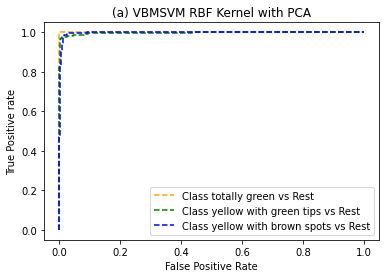

In [38]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_train, rbf_pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class totally green vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class yellow with green tips vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class yellow with brown spots vs Rest')
plt.title('(a) VBMSVM RBF Kernel with PCA')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')  

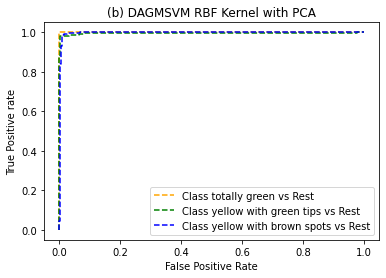

In [39]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_train, DAG_rbf_pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class totally green vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class yellow with green tips vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class yellow with brown spots vs Rest')
plt.title('(b) DAGMSVM RBF Kernel with PCA')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')  